In [1]:
using DifferentialEquations
using Plots
using Quadrature
using Roots

In [2]:
function ideal_gas_der(ρ, par)
    k,γ = par
    return k*γ*ρ^(γ - 1)
end
function integrate_EOS(ρ, der, par) #pressure comes from here
    prob = QuadratureProblem(der, 0.0, ρ, par)
    sol = solve(prob, QuadGKJL())#,reltol = 1e-10)
    return sol[1]
end

integrate_EOS (generic function with 1 method)

In [3]:
function make_TOV(ρ₀, dP, par)
    function TOV_equations!(du, u, par, r)
        myRho = u[1]
        myM = u[2]
        myP = u[3] 
        mydP = dP(myRho, par) #equal to dp/dρ

        if r <= 0.0
            du[1] = 0.0
            du[2] = 0.0
            du[3] = 0.0
        else
            du[3] = -((myM + 4π*(r^3)*myP)*(myRho + myP)) / (r*(r - 2*myM)) #this is pressure
            du[2] = (4π*r^2)*myRho #this is mass
            du[1] = du[3]/mydP #this is density
        end
    end
    u0 = [ρ₀, 0.0, integrate_EOS(ρ₀, dP, par)];
    Rmin = 0.0; Rguess = Inf ;
    prob = ODEProblem(TOV_equations!, u0, (Rmin, Rguess), par)
    TOV = init(prob, Tsit5(), dtmax=0.05, force_dtmin=true)
    R = 0.0
    while true
        T_Old = TOV.t #old radius
        step!(TOV)
        if TOV.u[1] < 0.0 #find zero
            f(r) = TOV.sol(r)[1] #density as function of radius
            R = find_zero(f, (T_Old, TOV.t), Order1())
            break
        end
    end
    return TOV.sol, R
end

make_TOV (generic function with 1 method)

In [4]:
function make_TOV_sequence(ρc, dP, par)
    mass = []
    radius = []
    for ρ₀ in ρc
        TOV,R = make_TOV(ρ₀, dP, par)
        push!(mass, TOV(R)[2])
        push!(radius,R)
    end
    return mass, radius
end

make_TOV_sequence (generic function with 1 method)

In [5]:
γ = 2; k = 123
P(ρ) = 123*ρ^2
dP(ρ) = 2*P(ρ)/ρ

print(P(1e-6),"\n", integrate_EOS(1e-6, ideal_gas_der, [123,2]))

1.23e-10
1.2299999999999996e-10

In [6]:
TOV, R = make_TOV(1e-3, ideal_gas_der, [123,2])
@time TOV, R = make_TOV(1e-3, ideal_gas_der, [123,2])
print(R)

  0.000521 seconds (3.04 k allocations: 271.320 KiB)
11.111051119437711

 17.901417 seconds (42.49 M allocations: 1.717 GiB, 2.85% gc time)


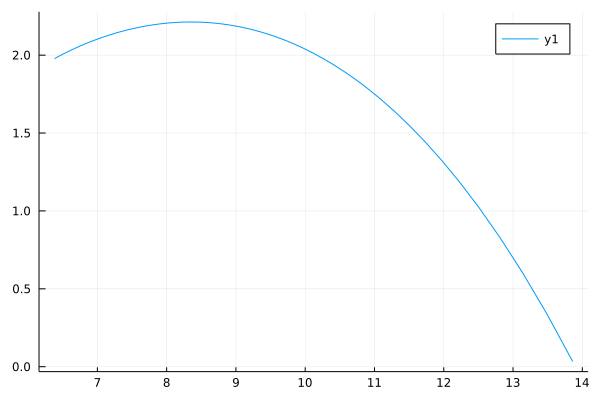

In [7]:
ρ₀ = collect(1.0e-2:1.0e-2:2.0e-2)
M,R = make_TOV_sequence(ρ₀, ideal_gas_der, [123,2])
@time begin
    ρ₀ = collect(1.0e-5:1.0e-4:1.0e-2)
    M,R = make_TOV_sequence(ρ₀, ideal_gas_der, [123,2])
    plot(R, M)
end

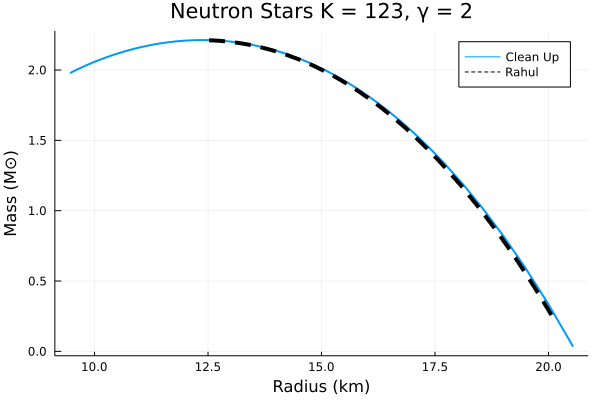

In [18]:
using DelimitedFiles
using Plots

g = readdlm("tov_seq_pwp2.dat")


TMASS = g[4:203]
TRAD = g[207:406]

plot(R*1.482, M, xlabel = "Radius (km)", ylabel = "Mass (M⊙)", label = "Clean Up", title = "Neutron Stars K = 123, γ = 2", linewidth = 2)
plot!(TMASS, TRAD, label = "Rahul", linestyle = :dash, linewidth = 4, color = :black)

In [17]:
k = 123.0; γ = 2.0

P(ρ) = k*ρ^γ
dP(ρ) = γ*P(ρ)/ρ

#TOV, R = make_TOV(1.0e-2, P, dP)

#plot(TOV, vars = 1) #(RADIUS, DENSITY)

#plot(ρ₀ * 6.17e17, M, xlabel = "Central Density (g/cm³)", ylabel = "Mass (M⊙)", label = "Mat", title = "Neutron Stars K = 123, γ = 2", linewidth = 2)

dP (generic function with 1 method)